# Object Detection (Lecture 13)

# 第一部分：2D 物体检测 (Object Detection)

物体检测的目标不仅是识别图像中有什么物体（分类），还要精确定位出它们的位置，通常是用一个**边界框 (Bounding Box)** 把它框出来。

## 单一物体检测

*   **任务**: 定位 (Localization) + 分类 (Classification)。
*   **输出**: 一个边界框和该框内物体的类别。
*   **参数化**: 边界框通常用4个值表示，如 `(x, y, w, h)`，即中心点坐标、宽度和高度。
*   **方法**: 将定位和分类两者结合，形成一个**多任务损失 (Multitask Loss)** 函数，同时优化。

### 回归损失函数

在预测边界框的坐标时，需要一个损失函数来衡量预测框与真实框的差距。
*   **L1 Loss**: $L_1 = \sum_i |\Delta_i|$。对异常值（大的误差）不敏感，比较鲁棒，但在接近收敛时（x=0附近）不够稳定。
*   **L2 Loss**: $L_2 = \sum_i \Delta_i^2$。对误差很敏感，收敛性好，但容易受异常值影响。
*   **Smooth L1 Loss**: Fast R-CNN 提出的一种结合了 L1 和 L2 优点的损失函数。在误差较小时表现像 L2，在误差较大时表现像 L1，做到了既稳定又鲁棒。

    $
    \text{smooth}_{L_1}(x) = 
    \begin{cases} 
    0.5x^2 & \text{if } |x| < 1 \\
    |x| - 0.5 & \text{otherwise}
    \end{cases}
    $

## 多物体检测

最大的挑战是**输出数量不固定**。有的图只有1个物体，有的图有几十个。早期的方法，如**滑窗法 (Sliding-Window)**，虽然直观，但需要对图像上成千上万个不同位置、不同大小的窗口都跑一遍分类器，计算量巨大，效率极低。

为了解决滑窗法的低效问题，研究者们提出了基于“区域提议 (Region Proposal)”的 R-CNN 系列算法

###   **R-CNN (Regions with CNN features)**:
1.  **区域提议**: 先用传统算法（如 Selective Search）在图像上生成约2000个可能包含物体的候选区域 (Region of Interest, RoI)。
2.  **特征提取**: 将每个候选区域强制缩放到固定大小 (如 224x224)，然后**独立地**送入一个卷积神经网络 (CNN) 提取特征。
3.  **分类与回归**: 用支持向量机 (SVM) 对提取的特征进行分类，并用一个线性回归器微调边界框的位置。
*   **缺点**:
    *   **速度极慢**: 对2000个区域重复进行CNN前向传播，计算冗余极大。
    *   **训练复杂**: 训练分为多个独立阶段（提议、CNN、SVM、回归器），不是端到端的。

###   **Fast R-CNN**:
核心思想是**共享计算**。
1.  **共享特征提取**: 不再对每个区域单独计算，而是**将整张图输入CNN一次**，得到一个全局的特征图 (feature map)。
2.  **RoI Pooling**: 将原始图像上的候选区域映射到特征图上，然后通过一个叫做 **RoI Pooling** 的层，将不同大小的特征区域转换成固定大小的特征向量。
3.  **统一预测**: 将固定大小的特征向量送入全连接层，**同时**完成分类和边界框回归。
*   **优点**: 速度比 R-CNN 快得多（训练快10倍，测试快近200倍），并且是端到端训练（除了区域提议）。
*   **瓶颈**: 区域提议步骤（Selective Search）成了新的速度瓶颈。

#### **投影**

1.  **背景**: 在 Fast R-CNN 中，我们不再像老方法 R-CNN 那样，把成千上万个候选框（proposal）分别送入神经网络。而是先把**整张大图**（左边 640x480 的猫图）输入到一个CNN网络里，得到一个浓缩后的**特征图 (feature map)**（右边 512x20x15 的立方体）。这个特征图虽然变小了（从 640x480 缩小到 20x15），但它包含了原图的高级语义信息。

2.  **操作**: “投影”就是要把原始图像上的那个绿色候选框（框住了猫），按照同样的缩放比例，映射到这个小小的特征图上。缩放比例是由CNN的结构决定的。

#### **“吸附”到网格单元**

RoI Pooling **取整**。它会把这些小数坐标强制“吸附”到最近的整数网格线上。

### Faster R-CNN

在Fast R-CNN中区域提议步骤（Selective Search）成了新的速度瓶颈。所以Faster就选择让CNN来进行 **找框**。

#### **第一步：铺设 Anchor Boxes**

在特征图的**每一个像素点**上，RPN 都预先放置了 $k$ 个（通常是9个）形状各异的虚拟框。这些框就叫**锚框 (Anchor)**。
*   有的框是方的，有的框是扁的，有的框是瘦高的。
*   有的框很大，有的框很小。

如果特征图大小是 $20 \times 15$，每个点放 9 个锚框，那总共就有 $20 \times 15 \times 9 = 2700$ 个锚框。这 2700 个框铺满了整张图。

#### **第二步：RPN 的判断 (分类 + 回归)**

RPN 拿着放大镜扫描这 2700 个锚框，对**每一个锚框**做两个判断：

1.  **有没有东西？(Objectness Score)**
    *   RPN 会给每个锚框打分：“这个框里像是有个物体（前景）” 还是 “这个框里全是背景（墙壁、草地）”。
    *   如果是背景，这个锚框就被扔掉了。

2.  **位置准不准？(Box Regression)**
    *   如果 RPN 觉得这个锚框里有物体，它会接着看：“这个锚框虽然套住了物体，但好像偏了一点，或者太大了。”
    *   于是它会输出 4 个修正值 `(dx, dy, dw, dh)`，意思是：“把这个锚框往左移一点，再变窄一点，就能完美套住物体了。”

#### **第三步：交接工作**

经过 RPN 的处理，把框变成了约 300 个**高质量的候选框 (Proposals)**。RPN 把这 300 个框交给Fast R-CNN 的后续部分。

#### 非极大值抑制 (Non-Maximal Suppression, NMS)**

检测器通常会针对同一个物体输出多个重叠的边界框，NMS 是一种后处理算法，用于剔除多余的框，只保留置信度最高且重叠度不高的那个。

NMS 的详细流程：

**准备工作:**

*   **B**: 一个包含**所有**原始预测框的列表。每个框都有自己的坐标和置信度分数。
*   **$\tau$ (IoU Threshold)**: 一个我们自己设定的**重叠度门槛**（比如 0.5）。如果两个框的重叠度（IoU）超过这个值，我们就认为它们框的是同一个物体。
*   **D**: 一个空的列表，用来存放我们最终筛选出来的结果。

**循环：**

1.  **选出最自信的王**：
    *   **操作**: 从列表 **B** 中，找到那个**置信度分数最高**的框。

2.  **“王”直接晋级**：
    *   **操作**: 将这个框从列表 **B** 中**移除**，并把它**放入**最终结果列表 **D** 中。这个框我们肯定要了。

3.  **“王”干掉身边的小弟**：
    *   **操作**: 遍历列表 **B** 中**剩下**的所有框。计算每一个框与 `box_king` 的 **IoU (交并比)**。
    *   **规则**: 如果某个框与 `box_king` 的 IoU **大于**我们设定的门槛 $\tau$（比如 > 0.5），说明它和“王”的重叠度太高了，只是个重复的检测。那就把它从列表 **B** 中**删除**。

从B中剩下部分选出最高的，循环上面步骤，直到原始列表 **B** 被清空。列表 **D** 中剩下的，就是经过 NMS 筛选后的最终检测结果——每个物体只保留一个最自信的边界框。

#### 总流程

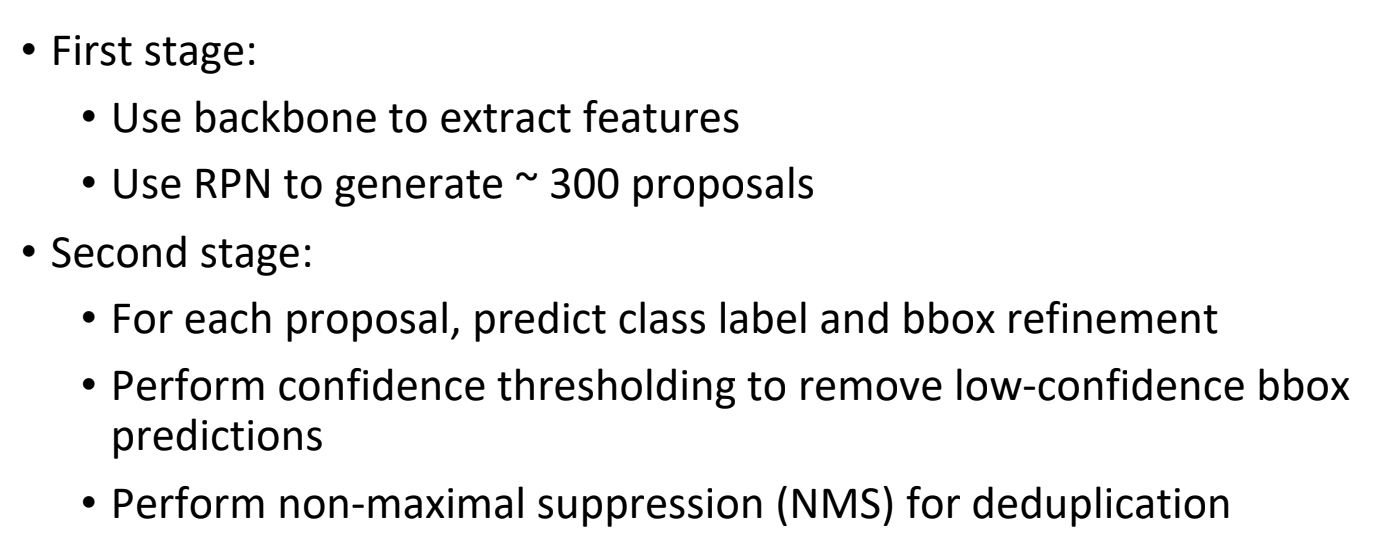

#### 优点-端到端

端到端系统: 就像一个完美的自动化工厂。你从一端（End）扔进去原材料（一张图片），它从另一端（End）直接吐出最终成品（带标签的边界框）。最重要的是，工厂内部的所有机器都是连接的，如果最终成品有瑕疵，这个“坏消息”可以一路反馈回去，调整生产线上的每一台机器。在神经网络里，这个“反馈机制”就是反向传播 (Backpropagation)，它要求整个流程是可微分 (differentiable) 的。

**为什么 Faster R-CNN 是一个端到端 (End-to-End) 的模型？**

核心原因有三点：**1. 提议生成的可微分性**，**2. 核心计算的共享**，以及 **3. 损失函数的统一**。

1. 提议生成的可微分性 (Differentiability of Proposal Generation)

*   **问题所在 (R-CNN / Fast R-CNN)**: 之前的模型依赖于外部的、非学习的算法来生成候选区域，最典型的是 **Selective Search**。Selective Search 是一个基于传统图像处理（如颜色、纹理、尺寸相似性）的启发式算法。它的内部操作是固定的，因此是**不可微分的 (non-differentiable)**。这意味着在训练过程中，损失函数计算出的梯度无法通过反向传播来优化这个区域提议步骤。区域提议的好坏与主网络模型的训练是**完全割裂**的。

*   **解决方案 (Faster R-CNN)**: Faster R-CNN 引入了**区域提议网络 (Region Proposal Network, RPN)**。RPN 本身就是一个小型的全卷积神经网络。作为神经网络，它的所有操作（卷积、激活函数等）都是**可微分的**。这就移除了整个流程中最大的障碍，使得梯度可以从最终的损失一路回传到负责生成候选框的模块。

2. 核心计算的共享 (Shared Core Computation)

*   **架构设计**: RPN 并不是独立运行在原始图像上的。它与后续的检测网络（Detector Head）**共享**同一个基础的卷积神经网络主干（Backbone, 如 VGG-16, ResNet）。
*   **工作流程**:
    1.  输入图像首先通过 Backbone，生成一个高级的特征图 (feature map)。
    2.  这个**唯一的特征图**被同时送往两个分支：
        *   **RPN 分支**: 在特征图上生成候选区域。
        *   **检测器分支**: 利用 RPN 生成的候选区域，从同一个特征图上提取特征（通过 RoI Pooling），进行最终的分类和边界框回归。
*   **关键意义**:
    *   **效率**: 计算量最大的卷积操作只进行一次，避免了冗余。
    *   **协同优化**: 因为 Backbone 被两个分支共享，它在训练时会同时接收来自 RPN 和检测器的梯度。这会迫使 Backbone 学习到一种**对两个任务都最优**的特征表示。

3. 损失函数的统一 (Unified Loss Function)

$L_{total} = \underbrace{L_{cls}^{RPN} + L_{reg}^{RPN}}_{\text{第一阶段：RPN 的损失}} + \underbrace{L_{cls}^{Detector} + L_{reg}^{Detector}}_{\text{第二阶段：最终检测器的损失}}$

*   **训练目标**: Faster R-CNN 的训练由一个**单一的、统一的损失函数**驱动。这个总损失是四个子损失的和：
    1.  **RPN 分类损失**: 判断锚框是前景还是背景。
    2.  **RPN 回归损失**: 初步修正锚框位置。
    3.  **检测器分类损失**: 判断候选区域的具体类别。
    4.  **检测器回归损失**: 精细修正候选区域的位置。
*   **反向传播**: 在训练的每一步，计算出这个**总损失**关于网络所有参数的梯度。由于整个网络（Backbone + RPN + Detector Head）是一个**连续的、完全可微分的计算图**，这个梯度可以无障碍地从头传到尾。
*   **联合训练**: 通过最小化这个统一的损失函数，优化器（如 SGD）可以**同时更新** RPN、检测器以及被它们共享的 Backbone 的所有权重。这实现了所有组件的**联合训练 (Joint Training)**，而不是像 R-CNN 那样分阶段、独立地训练。




### 如何评价模型好坏

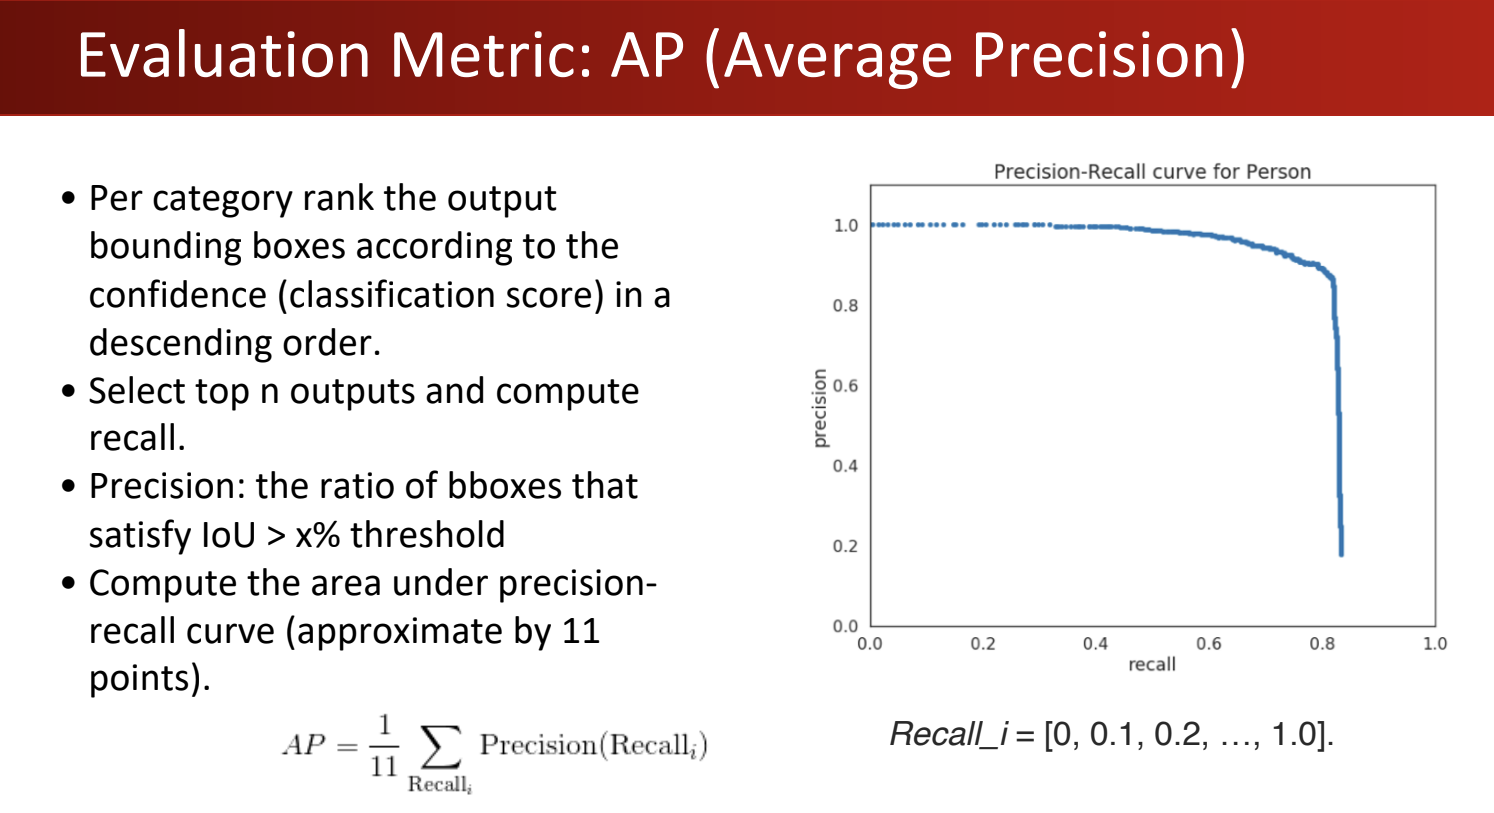

物体检测既要**找得准**，又要**找得全**。AP 就是一个能同时衡量这两个方面的黄金标准。

#### 两个核心概念：查准率 (Precision) 和 查全率 (Recall)

想象一下，一个池塘里总共有 10 条鱼 (**Ground Truth**)。你用你的新模型（一张渔网）撒了一网，捞上来 8 条东西。

*   **查准-率 (Precision)**：**关心你捞上来的东西里，有多少是真鱼。**
    *   你捞上来的 8 条东西里，有 6 条是真鱼，还有 2 个是破鞋（**False Positive**，误报）。
    *   那么你的 Precision = 6 / 8 = 75%。
    *   **Precision 回答的是：“你预测的结果有多准？”**

*   **查全率 (Recall)**：**关心池塘里所有的鱼，你捞上来了多少。**
    *   池塘里总共有 10 条鱼，你捞上来了 6 条。
    *   那么你的 Recall = 6 / 10 = 60%。
    *   **Recall 回答的是：“你有没有把该找的都找到了？”**

**关键的矛盾**：Precision 和 Recall 往往是相互制约的。
*   如果你把渔网收得很紧（只保留**置信度非常高**的预测结果），你捞上来的基本都是真鱼（Precision 高），但很可能会漏掉很多鱼（Recall 低）。
*   如果你把渔网撒得很大（保留**置信度很低**的预测结果），你可能把池塘里所有的鱼都捞上来了（Recall 高），但里面也捞了一大堆破鞋和水草（Precision 低）。

#### 如何画出那条曲线？(Precision-Recall Curve)

既然只看一个点的 Precision 或 Recall 不公平，那我们就看**所有情况**下的表现。

这张幻灯片的流程就是在教我们如何画出这条曲线：

1.  **“Per category rank the output...” (按置信度排序)**
    *   **操作**: 首先，只看一个类别，比如“人 (Person)”。把你的模型在所有测试图片上预测为“人”的**所有**边界框都收集起来。然后，按照**置信度分数**从高到低排个队。
    *   **比喻**: 把你捞上来的所有东西，按照“我有多确定这是条鱼”的信心程度，从最像鱼的到最不像鱼的排成一排。

2.  **“Select top n outputs and compute recall” (从头开始，逐个评估)**
    *   **操作**: 我们从这个排序列表的**最顶端**（最自信的那个预测框）开始，一个一个地往下看。每多看一个框，我们就重新计算一次当前的 Precision 和 Recall。
    *   **例子**: 假设测试集里总共有 5 个 Ground Truth 的人。
        *   **只看第1个预测框 (最自信的)**：假设它是对的（IoU > 0.5）。
            *   此时，我们预测了1个，对了1个 $\rightarrow$ Precision=1/1=100%。
            *   总共5个人，我们找到了1个 $\rightarrow$ Recall=1/5=20%。
            *   在图上画一个点：`(Recall=0.2, Precision=1.0)`。
        *   **看前2个预测框**: 假设第2个也是对的。
            *   我们预测了2个，对了2个 $\rightarrow$ Precision=2/2=100%。
            *   总共5个人，我们找到了2个 $\rightarrow$ Recall=2/5=40%。
            *   在图上画一个点：`(Recall=0.4, Precision=1.0)`。
        *   **看前3个预测框**: 假设第3个是错的（是个假人模特）。
            *   我们预测了3个，但只对了2个 $\rightarrow$ Precision=2/3=66.7%。
            *   总共5个人，我们还是只找到了2个 $\rightarrow$ Recall=2/5=40%。
            *   在图上画一个点：`(Recall=0.4, Precision=0.667)`。
    *   ...不断重复这个过程，直到评估完所有的预测框。

3.  **连接所有的点**，就得到了右边那条**从左上角向右下角**延伸的 **Precision-Recall 曲线**。
    *   一个好的模型，它的曲线会尽可能地**贴近右上角**，也就是说，在 Recall 很高的情况下，Precision 依然能保持很高。

#### AP

*   **“Compute the area under precision-recall curve” (计算曲线下面积)**
    *   **AP (Average Precision)**，顾名思义就是“平均精度”。在现代定义中，它就是这条 **Precision-Recall 曲线下方的面积 (Area Under Curve, AUC)**。
    *   面积越大，说明模型在各种 Recall 水平下都能保持高 Precision，性能就越好。

*   $AP = \frac{1}{11} \sum_{Recall_i} Precision(Recall_i)$
    *   这是一个**比较古老**的、简化的计算方法（源于 Pascal VOC 竞赛）。它不是计算完整的曲线面积，而是只在 Recall 等于 `0, 0.1, 0.2, ..., 1.0` 这 **11** 个固定的点上进行采样，然后取这些点上 Precision 值的**平均数**来近似代替总面积。

---

### 金字塔底层：基本判断单元

#### 1. IoU (Intersection over Union) - “相似度打分器”

*   **这是什么？** 衡量**单个**预测框和**单个**真实框（Ground Truth）重叠程度的指标。
*   **作用？** 给预测框的**定位精度**打分，范围。分数越高，说明框得越准。
*   **它是金字塔的基石**，后面的一切都建立在它之上。

#### 2. TP, FP, FN - “对错判断器”

*   **这是什么？** 基于 IoU 的打分，我们设定一个**及格线 (IoU Threshold)**，比如 `0.5`。然后对每一个预测框做出判断：
    *   **True Positive (TP)**: 预测对了。一个预测框与一个真实框的 IoU > `0.5`，且类别正确。
    *   **False Positive (FP)**: 预测错了。
        *   定位错误：IoU ≤ `0.5`。
        *   类别错误：比如把猫预测成了狗。
        *   重复检测：对同一个真实框进行了多次检测。
    *   **False Negative (FN)**: 漏报了。一个真实框没有被任何预测框成功匹配到。

---

### 金字塔中层：单一阈值下的性能曲线

#### 3. Precision & Recall - “硬币的两面”

*   **这是什么？** 基于上面统计的 TP, FP, FN 数量，我们计算出两个核心指标：
    *   **Precision (查准率)** = $\frac{TP}{TP+FP}$ = $\frac{\text{你预测对的数量}}{\text{你总共预测的数量}}$
        *   **衡量你有多“准”**：你的预测结果中有多少是靠谱的。
    *   **Recall (查全率)** = $\frac{TP}{TP+FN}$ = $\frac{\text{你预测对的数量}}{\text{所有应该被找到的数量}}$
        *   **衡量你有多“全”**：你有没有把该找的都找到。

*   **核心矛盾**: 这两者通常是此消彼长的。

#### 4. Precision-Recall (P-R) 曲线

*   **这是什么？** 我们不是只看一个固定的置信度分数，而是通过**从高到低改变置信度阈值**，得到一系列的 (Recall, Precision) 点对，把它们连成一条曲线。
*   **作用？** 全面地展示一个模型在**所有**置信度水平下的性能表现。一条好的曲线会紧贴右上角。

---

### 金字塔顶层：最终的综合评分

#### 5. AP (Average Precision) - “单个学科的期末总分”

*   **这是什么？** 它衡量的是模型在**单个类别**（比如“猫”）上的综合性能。
*   **如何计算？** 计算该类别 **P-R 曲线下方的面积 (Area Under Curve, AUC)**。
*   **核心逻辑**: AP 将模型在所有 Recall 水平下的 Precision 表现**压缩成一个单一的、全面的分数**。AP 越高，说明这个模型在这个类别上的表现越好。
*   **重要细节**: 这个 AP 的计算是基于一个**预先固定的 IoU 阈值**（比如 `0.5`）的。所以，更严谨的叫法是 **AP@.50** 或 **AP₅₀**。

#### 6. mAP (mean Average Precision) - “所有学科的平均分”

*   **这是什么？** 它衡量的是模型在**所有类别**上的**平均**性能。
*   **如何计算？**
    1.  为数据集中的**每一个类别**都独立计算出一个 AP 值 (AP_cat, AP_dog, AP_car, ...)。
    2.  把所有这些 AP 值加起来，再**求一个平均数**。
*   **作用？** 这是**衡量模型整体性能**最常用、最重要的指标。

---

### 终极进化：更严格、更公平的 mAP (COCO mAP)

现在，我们把 **IoU** 这个变量也加进来，让评价体系变得更严格。

*   **问题**: 只用 IoU > `0.5` 作为及格线 (AP₅₀) 太宽松了，它无法区分“框得凑合”和“框得精准”的模型。
*   **解决方案**: 使用**多个、更严格的 IoU 阈值**来“考试”，然后取平均。
*   **COCO mAP**:
    1.  首先，在 IoU 阈值为 `0.50` 时，计算出所有类别的 AP，再求平均，得到 **mAP@.50**。
    2.  然后，在 IoU 阈值为 `0.55` 时，重复一遍，得到 **mAP@.55**。
    3.  ...
    4.  一直到 IoU 阈值为 `0.95`，得到 **mAP@.95**。
    5.  最后，把这 **10 个 mAP 值 (`mAP@.50` 到 `mAP@.95`) 再求一个平均数**。

这个最终的结果，就是我们现在在学术论文和比赛中通常所说的 **mAP**

### 逻辑梳理总结

**IoU $\rightarrow$ (TP, FP, FN) $\rightarrow$ (Precision, Recall) $\rightarrow$ P-R Curve $\rightarrow$ AP (单个类别, 单个IoU阈值) $\rightarrow$ mAP (所有类别, 单个IoU阈值) $\rightarrow$ COCO mAP (所有类别, 多个IoU阈值)**
